In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_02 import *
import torch.nn.functional as F
import pandas as pd

# Initial Setup

## Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
c = y_train.max().item()+1
nh = 50
n, m, nh, c

(50000, 784, 50, 10)

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh),
                       nn.ReLU(nh),
                       nn.Linear(nh, n_out)]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [7]:
model = Model(m, nh, c)

In [8]:
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

# Cross entropy loss 

## DIY Technique 

### Softmax 

In [52]:
x = pred[:2].data;
x, x.shape

(tensor([[ 0.0687,  0.0117, -0.1907, -0.1749, -0.0724, -0.1359, -0.0989, -0.1093,
           0.1319,  0.0167],
         [ 0.0569, -0.0305, -0.1624, -0.2878, -0.1782, -0.0963, -0.0688, -0.2359,
           0.1240, -0.1384]]), torch.Size([2, 10]))

In [53]:
s1 = x.exp()
s1, s1.shape

(tensor([[1.0711, 1.0118, 0.8264, 0.8396, 0.9301, 0.8730, 0.9059, 0.8964, 1.1409,
          1.0169],
         [1.0586, 0.9699, 0.8501, 0.7499, 0.8368, 0.9082, 0.9335, 0.7898, 1.1321,
          0.8707]]), torch.Size([2, 10]))

In [54]:
s2 = x.exp().sum(-1)
s2, s2.shape

(tensor([9.5120, 9.0997]), torch.Size([2]))

In [55]:
s3 = x.exp().sum(-1, keepdim=True)
s3, s3.shape

(tensor([[9.5120],
         [9.0997]]), torch.Size([2, 1]))

In [56]:
s4 = x.exp() / x.exp().sum(-1)
s4, s4.shape

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

In [57]:
s5 = x.exp() / x.exp().sum(-1, keepdim= True)
s5, s5.shape

(tensor([[0.1126, 0.1064, 0.0869, 0.0883, 0.0978, 0.0918, 0.0952, 0.0942, 0.1199,
          0.1069],
         [0.1163, 0.1066, 0.0934, 0.0824, 0.0920, 0.0998, 0.1026, 0.0868, 0.1244,
          0.0957]]), torch.Size([2, 10]))

___

Log_SoftMax function:

In [118]:
def log_softmax(x):
    return ( x.exp() / x.exp().sum(-1, keepdim=True)).log()

In [59]:
y_train[:4]

tensor([5, 0, 4, 1])

In [62]:
sm_pred = softmax(pred)
sm_pred.shape

torch.Size([50000, 10])

### Negative log likelyhood

NLL is the negative sum of actual multiplied by the prediction.

Since actuals are 1-hot encoded, NLL is just negative prediction.

In [72]:
p = pred[:2].data; p

tensor([[ 0.0687,  0.0117, -0.1907, -0.1749, -0.0724, -0.1359, -0.0989, -0.1093,
          0.1319,  0.0167],
        [ 0.0569, -0.0305, -0.1624, -0.2878, -0.1782, -0.0963, -0.0688, -0.2359,
          0.1240, -0.1384]])

In [73]:
t = y_train[:2]; t

tensor([5, 0])

In [77]:
p.shape

torch.Size([2, 10])

With interger array indexing, you can select precise elements of each array in pred:

In [81]:
p[range(2), t]

tensor([-0.1359,  0.0569])

___

In [23]:
def nll(inp, targ):
    return - inp[ range(inp.shape[0]), targ ].mean()

In [119]:
loss = nll(log_softmax(model(x_train)), y_train); loss

tensor(2.3065, grad_fn=<NegBackward>)

### Exp() in dangerous !

Because values quickly tend to infinity, wich is not easyly handled by the compute (overflow)

In [108]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [116]:
test1 = log_softmax(pred)

We still wand to diminish as much as possible the exp() values.

We can use LogSumExp my factoring the biggest a.exp() possible:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

In [94]:
c = pred[:2]; c

tensor([[ 0.0687,  0.0117, -0.1907, -0.1749, -0.0724, -0.1359, -0.0989, -0.1093,
          0.1319,  0.0167],
        [ 0.0569, -0.0305, -0.1624, -0.2878, -0.1782, -0.0963, -0.0688, -0.2359,
          0.1240, -0.1384]], grad_fn=<SliceBackward>)

In [100]:
c.max(-1) # takes the max val and it's index along rows

torch.return_types.max(
values=tensor([0.1319, 0.1240], grad_fn=<MaxBackward0>),
indices=tensor([8, 8]))

In [103]:
m = c.max(-1)[0] # returns only the max values
m

tensor([0.1319, 0.1240], grad_fn=<MaxBackward0>)

### Refactor log_softmax

In [21]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

In [110]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [22]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [121]:
test_near( nll(log_softmax(model(x_train)), y_train), loss)

## In pytorch:

In [122]:
test_near( F.nll_loss( F.log_softmax( model( x_train), -1), y_train), loss)

In [123]:
test_near( F.cross_entropy( model( x_train), y_train), loss)

# Basic trainning Loop

- Get predictions on a batch
- compare with actuals and process Loss
- process gradients of the loss respect to each parameter in the model
- update parameters

In [9]:
def accuracy( pred , targ):
    # finds the predictions that are True and mean over the whole batch
    return (torch.argmax(pred, dim=1) == targ).float().mean()

In [16]:
bs = 64
lr = 0.5
epochs = 1
n,m = x_train.shape
loss_func = F.cross_entropy
n

50000

In [228]:
model = Model(m, 50, c)

In [229]:
rec = {'loss':[], 'acc':[]}

for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        
        # Define batch intexes
        start_i = i * bs
        end_i   = start_i + bs
        
        # Create batches
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        
        # Predict and process loss
        pred = model(xb)
        
        loss = loss_func(pred, yb)
        rec['loss'] += [loss.data]
        rec['acc'] += [accuracy(pred, yb).data]
        
        
        # Process grads
        loss.backward()
        
        # Update parameters
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [230]:
df = pd.DataFrame(rec).astype('float')

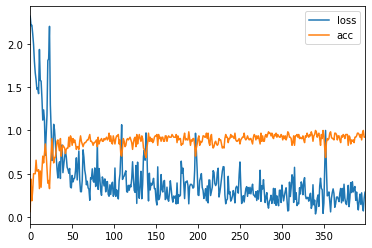

In [231]:
df.iloc[:400].plot()

# Parameters and optim

## Parameters

To use an optimizer we need to be able to grab the parameters of the model.

In [39]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [40]:
model = Model(m, nh, 10)

In [13]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [14]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [41]:
[o.shape for o in model.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [16]:
def fit():
    rec = {'loss':[], 'acc':[]}

    for epoch in range(epochs):
        for i in range((n-1)//bs+1):

            # Define batch intexes
            start_i = i * bs
            end_i   = start_i + bs

            # Create batches
            xb = x_train[start_i : end_i]
            yb = y_train[start_i : end_i]

            # Predict and process loss
            pred = model(xb)

            loss = loss_func(pred, yb)
            rec['loss'] += [loss.data]
            rec['acc'] += [accuracy(pred, yb).data]


            # Process grads
            loss.backward()

            # Update parameters
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    model.zero_grad()
    return rec

Pytorch uses __setattr__ to register the submodules as parameters.

In [29]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'): 
            self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [30]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [31]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules

### DIY

In [10]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [42]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [43]:
model = Model(layers)

In [44]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [45]:
[o.shape for o in model.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### With Pytorch

#### Torch nn.ModuleList

In [9]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [47]:
model = SequentialModel(layers)

In [48]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

#### Torch nn.Sequential

Convenient class to create a model out of layer list:

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [50]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
nn.Sequential??

## Optimizer

We want to refactor to be able to do:

- optim.step()
- optim.zero_grad()

### DIY technique

In [30]:
class Optimizer():
    
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [14]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, c))

In [31]:
opt = Optimizer(model.parameters())

In [17]:
def fit():
    rec = {'loss':[], 'acc':[]}

    for epoch in range(epochs):
        for i in range((n-1)//bs+1):

            # Define batch intexes
            start_i = i * bs
            end_i   = start_i + bs

            # Create batches
            xb = x_train[start_i : end_i]
            yb = y_train[start_i : end_i]

            # Predict and process loss
            pred = model(xb)

            loss = loss_func(pred, yb)
            rec['loss'] += [loss.data]
            rec['acc'] += [accuracy(pred, yb).data]


            # Process grads
            loss.backward()
            opt.step()
            opt.zero_grad()
    return rec

In [33]:
r = fit()

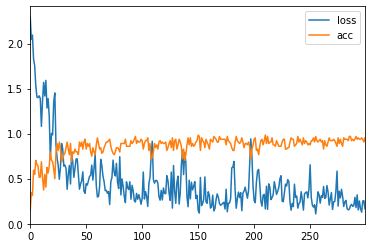

In [37]:
(pd.DataFrame(r)).astype('float').iloc[:300].plot()

### With Pytorch 

In [23]:
from torch import optim

In [ ]:
optim.SGD.step??
Signature: optim.SGD.step(self, closure=None)
Source:   
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
        
        #### Grab all parameters to precess optimization ####
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)  #### No idea how this works...
                    
                if momentum != 0:
                    param_state = self.state[p]     #### ???
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [15]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [30]:
model, opt = get_model()

In [31]:
r = fit()

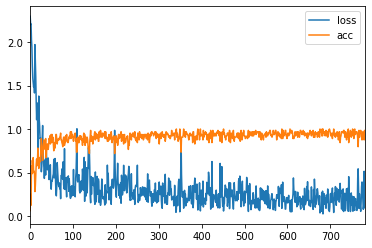

In [34]:
pd.DataFrame(r).astype('float').plot()

# Dataset and Dataloader

## DIY Technique

### Dataset

In [18]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [19]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [37]:
assert len(train_ds)==len(x_train)

In [39]:
xb, yb = train_ds[:20]
assert xb.shape==(20,28*28)
assert yb.shape==(20,)

### DataLoader

In [40]:
class Dataloader():
    
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i : i+self.bs]

In [41]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [42]:
xb, yb = next(iter(train_dl))

In [43]:
assert xb.shape == (bs, 28*28)

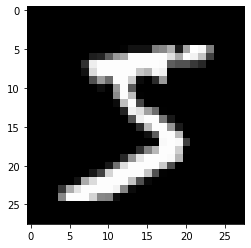

In [46]:
plt.imshow(xb[0].view(28,28))

In [47]:
def fit():
    rec = {'loss':[], 'acc':[]}

    for epoch in range(epochs):
        for xb, yb in train_dl:

            # Predict and process loss
            pred = model(xb)

            loss = loss_func(pred, yb)
            rec['loss'] += [loss.data]
            rec['acc'] += [accuracy(pred, yb).data]


            # Process grads
            loss.backward()
            opt.step()
            opt.zero_grad()
    return rec

In [49]:
model, opt = get_model()

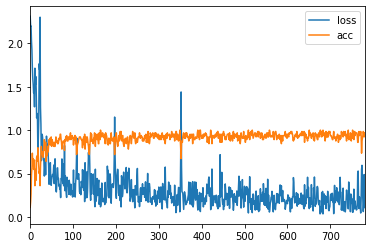

In [50]:
pd.DataFrame(fit()).astype('float').plot()

In [51]:
assert accuracy(model(xb), yb) > 0.7

### Random Sampling 

We will use this torch functions to generate random indexes:

In [52]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [54]:
torch.randperm(10)

tensor([7, 3, 9, 1, 2, 4, 5, 6, 0, 8])

In [56]:
class Sampler():
    
    def __init__(self, ds, bs, shuffle=False):
        self.n = len(ds)
        self.bs= bs
        self.shuffle = shuffle
    
    def __iter__(self):
        # Create a new index list
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

In [61]:
small_ds = Dataset(*train_ds[:10])

In [64]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

Items are provided separately but Pytorch needs batches so we neet to stack them:

In [57]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [65]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds = ds
        self.sampler = sampler
        self.collate_fn = collate_fn
    
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [66]:
train_s = Sampler(train_ds, bs, shuffle=True)
valid_s = Sampler(valid_ds, bs, shuffle=False)

In [67]:
train_dl = DataLoader(train_ds, train_s, collate_fn=collate)
valid_dl = DataLoader(valid_ds, valid_s, collate_fn=collate)

tensor(8)

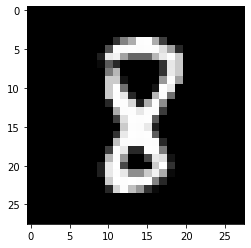

In [70]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

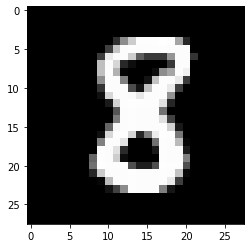

In [71]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

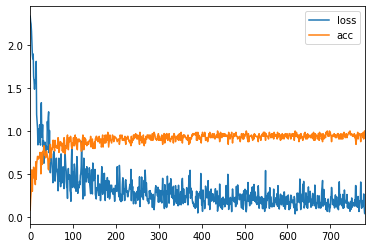

In [72]:
model, opt = get_model()
pd.DataFrame(fit()).astype('float').plot()
assert accuracy(model(xb), yb) > 0.7

## With Pytorch

In [13]:
from torch.utils.data import DataLoader, SequentialSampler , RandomSampler

In [76]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [78]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=4)
valid_dl = DataLoader(valid_ds, bs*2, shuffle=False, num_workers=4)

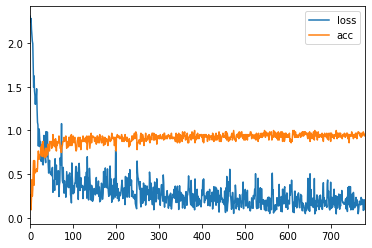

In [79]:
model, opt = get_model()
pd.DataFrame(fit()).astype('float').plot()
assert accuracy(model(xb), yb) > 0.7

#### Validation

In [57]:
def get_stats(x):
    return [round(float(x.mean().data),5), round(float(x.std().data), 5)]

In [55]:
{k: get_stats(p) for k,p in model.named_parameters()}

{'0.weight': [-0.0061, 0.0817],
 '0.bias': [0.0186, 0.1815],
 '2.weight': [0.0016, 0.4441],
 '2.bias': [0.0364, 0.2809]}

In [89]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    rec_train = {'loss':[0.],
                 'acc':[0.]}
    rec_valid = {'loss':[0.],
                 'acc':[0.]}
    
    rec_param = {k:[] for k,p in model.named_parameters()}
    
    for epoch in range(epochs):
        
        model.train()
        
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            rec_train['loss'] += [loss]
            rec_train['acc']  += [accuracy(pred, yb)]
            
            for k,p in model.named_parameters():
                rec_param[k] += [get_stats(p)]
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        
        model.eval()
        
        with torch.no_grad():
            
            tot_loss, tot_acc = 0., 0.
            
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
                
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        
        rec_valid['loss'] += [rec_valid['loss'][-1]]*(len(train_dl)-1)
        rec_valid['acc'] += [rec_valid['acc'][-1]]*(len(train_dl)-1)
        
        rec_valid['loss'] += [tot_loss/nv]
        rec_valid['acc']  += [tot_acc/nv]
        
    return rec_train, rec_valid, rec_param
            

In [76]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, **kwargs),
           DataLoader(valid_ds, batch_size=bs, **kwargs))

In [113]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
rec_train, rec_valid, rec_param = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1877) tensor(0.9433)
1 tensor(0.1462) tensor(0.9566)
2 tensor(0.1142) tensor(0.9670)
3 tensor(0.1181) tensor(0.9658)
4 tensor(0.1183) tensor(0.9656)


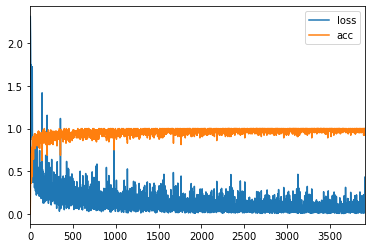

In [114]:
pd.DataFrame(rec_train).astype('float').plot()

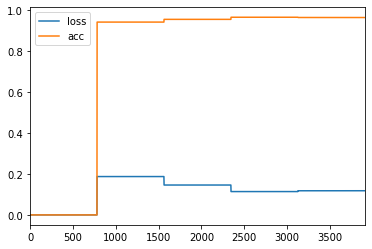

In [115]:
pd.DataFrame(rec_valid).astype('float').plot()

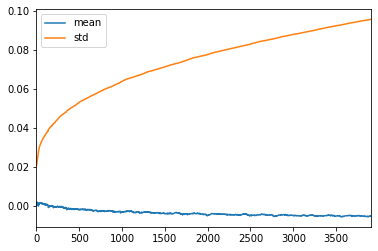

In [116]:
pd.DataFrame({'mean': [v[0] for v in rec_param['0.weight']],
              'std' : [v[1] for v in rec_param['0.weight']]}).astype('float').plot()

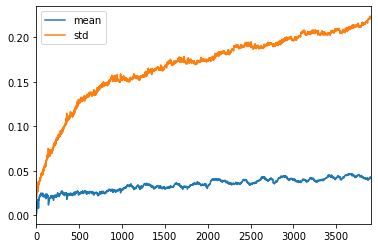

In [117]:
pd.DataFrame({'mean': [v[0] for v in rec_param['0.bias']],
              'std' : [v[1] for v in rec_param['0.bias']]}).astype('float').plot()